In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.dpi"] = 125

from google.colab import drive
drive.mount('/content/gdrive')
filepath = '/content/gdrive/My Drive/Courses/Computational/Homework3/'


Nghost = 2 # Number of ghost zones

# Define a class to hold the parameters of the hydrodynamics simulation
# and run the sim and handled the results
class Burgers(object):
    def __init__(self, Ncells, IC, outCad=0, slopeLimiter = 'minmod'): 
        self._outCad = outCad
        self._t = 0.0
        self._N = Ncells+2*Nghost
        self._dx = 1.0/Ncells 
        self._x = np.linspace((0.5-Nghost)*self._dx,1+(Nghost-0.5)*self._dx, Ncells+2*Nghost)
        self._u = self._getIC(IC, self._x) 
        self._dt = 0.25*self._dx
        self._slopeLimiter = slopeLimiter
    def _getIC(self,IC, x):
        if (IC=="sine"):
            return 0.35+0.25*np.sin(4.0*np.pi*x)
        elif (IC=="step"):
            f = np.ones_like(x)
            f[abs(x-0.5)<0.25] = 0.5
            return f
        else:
            raise ValueError("IC undefined") 
    def _physFlux(self, u):
        return 0.5*u**2
    def _flux(self, ul, ur): #ul/ur is left/right of interface
        #Roe's method
        uavg = 0.5 * (ul + ur)
        delta = ur - ul
        return (
                0.5*(self._physFlux(ul)+self._physFlux(ur) - 0.5*abs(uavg)*delta)
               )
    def _uPlusMinus(self, u):
        #minmod
        
        #print (slope)
        if self._slopeLimiter == 'None':
            # print ("using Linear interoplation")
            # Linear interpolation to interface
            up = 1.0*u
            up[:-1] = 0.5*(u[1:]+u[:-1])
            um = 1.0*u
            um[1:] = 0.5*(u[1:]+u[:-1])
            return (up,um)
        elif self._slopeLimiter == 'minmod': 
            # print ("using minmod")
            # minmod
            slope = np.zeros_like(u)
            deltau = u[1:] - u[:-1] #all values except first and last u
            slope[1:-1] = deltau[1:]
            I = abs(deltau[1:]) > abs(deltau[:-1]) #gives true or false array
            slope[1:-1][I] = deltau[:-1][I]
            slope[1:-1][deltau[1:]*deltau[:-1] <= 0] = 0
            uL = u+0.5*slope
            uR = u-0.5*slope
            return (uL, uR)
        elif self._slopeLimiter == 'WENO':
            print ('Other slope limiter...currently ', 'WENO')
            return print ('Need to define method') #(uL,uR)
    def _udot(self, u):
        #Calculate left and right hand states at interfaces
        up,um = self._uPlusMinus(u)
        F = np.zeros(len(u)+1)
        #Calculate flux at interfaces
        F[1:-1] = self._flux(up[:-1],um[1:])
        return (1.0/self._dx)*(F[:-1]-F[1:])
    def _applyBC(self, u):
        #Copy over ghost cells assuming periodic BCs
        ubc = 1.0*u
        ubc[0:Nghost] = u[-(2*Nghost):-Nghost]
        ubc[-Nghost:] = u[Nghost:2*Nghost]
        return ubc
    def _step(self):
        #Use Runge-Kutta 2
        uhalf = self._u + 0.5*self._dt*self._udot(self._u)
        uhalf = self._applyBC(uhalf)
        self._u += self._dt*self._udot(uhalf)
        self._u = self._applyBC(self._u)
        self._t += self._dt
    def evolve(self, tf, save=True, show=False):
        while(self._t<tf):
            if (self._outCad>0): self._output(save=save, show=show)
            self._step()
        if (self._outCad>0): self._output(save=save, show=show)
    def _output(self, save=True, show=False):
        nstep = np.rint(self._t/self._dt)
        if (nstep%self._outCad!=0): return
        plt.clf()
        plt.ylabel(r"u")
        plt.xlabel(r"x")
        plt.title("t=%1.2f"%self._t)
        plt.plot(self._x[Nghost:-Nghost], self._u[Nghost:-Nghost], "k-")
        #plt.ylim([0.1,0.6])
        if show:
            plt.show()
        if save:
            plt.savefig("fig_%d.png" % (nstep/self._outCad)) 
    def plotReconstruction(self):
        up,um = self._uPlusMinus(self._u)
        stencil = 0.5*self._dx*np.array([-1,0,1])
        plt.plot(self._x[Nghost:-Nghost],self._u[Nghost:-Nghost],"ro")
        for n in range(Nghost,self._N-Nghost):
            plt.plot(stencil+self._x[n],[um[n],self._u[n],up[n]],"k")
        plt.xlabel(r"$x$")
        plt.ylabel(r"$u$")
        plt.show()
    def getSoln(self):
        return self._u[Nghost:-Nghost]
    def getDomain(self):
        return self._x[Nghost:-Nghost]
    def getMass(self):
        return self._dx*np.sum(self._u[Nghost:-Nghost])


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### Plotting the Solutions

fractional change in mass =  0.0


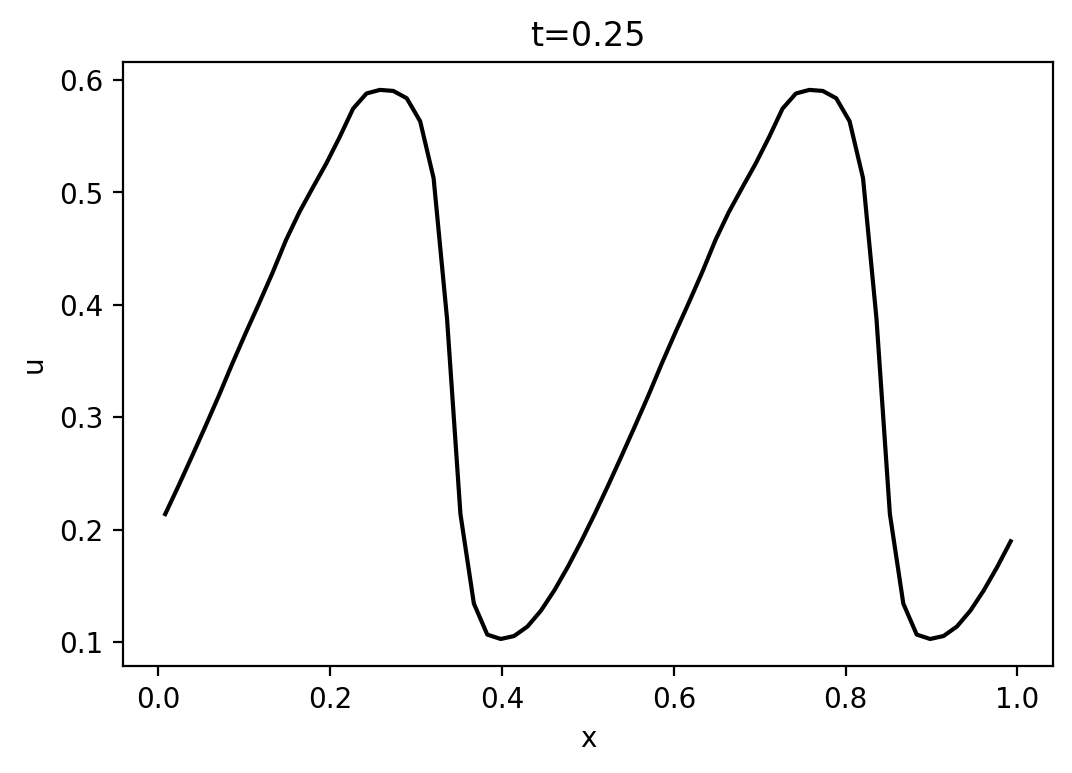

In [0]:
# delete output files from a possible previous run
os.system('rm fig*.png animation.mp4')

# Parameter values:

# Number of cells in the simulation
Ncells = 64

# Initial conditions -- 'sine' or 'step'
IC = 'sine'

# Output cadence -- how often to produce a plot
outCad = 8

# Final time -- how long to run the simulation for
tf = 0.25

burgers = Burgers(Ncells, IC, outCad=outCad)

# If you pass 'show=True', it will display a series of plots;
# if you pass 'save=True' (the default), it will also save a series of .png plots...
M0 = burgers.getMass()
burgers.evolve(tf, save=False, show=False)
Mf = burgers.getMass()


print ("fractional change in mass = ", abs(M0 - Mf)/ M0)
# ... which you can convert into a movie "animation.mp4".
# If you're running on Symmetry, you will have to download the animation.mp4 file to your computer to view it.
os.system('ffmpeg -r 12 -i fig_%d.png -qscale:v 0 -pix_fmt yuv420p -c:v libx264 -crf 20 -r 24 animation.mp4');


## Show Convergence Order

In [0]:
def convergence(tf_vals, Ncells_vals, IC, outCad, slope_limiter_types):
    n_sl, n_tf, n_dx = len(slope_limiter_types), len(tf_vals), len(Ncells_vals)
    error = np.zeros((n_sl, n_tf, n_dx))
    u_profiles = []
    for i_sl in range(n_sl):
        ## Choose the slope limiter type
        slope_limiter = slope_limiter_types[i_sl]
        print ('slope limiter = ', slope_limiter)
        burgers_og = Burgers(8*Ncells_vals[0], IC, outCad=outCad, slopeLimiter = slope_limiter)
        burgers = [ Burgers(Ncells, IC, outCad=outCad, slopeLimiter = slope_limiter) for Ncells in Ncells_vals]
        u_profiles_sl = []
        for i_tf in range(n_tf):
            ## Evovle to specified time tf
            tf = tf_vals[i_tf]
            print ('tf = ', tf)
            burgers_og.evolve(tf, save=False, show=False)
            x_original = burgers_og.getDomain()
            u_original = burgers_og.getSoln()
            u_profiles_dx = []
            for i_dx in range(n_dx):
                ## compute profiles for different values of spacing dx
                print (Ncells_vals[i_dx])
                burgers[i_dx].evolve(tf, save=False, show=False)
                # interpolate
                u_interp = np.interp(x_original, burgers[i_dx].getDomain(), burgers[i_dx].getSoln())
                # compute the error
                error_1 = np.mean( abs( (u_original - u_interp) ) )
                error[i_sl][i_tf][i_dx] = error_1

                u_profiles_dx.append(u_interp)
            u_profiles_sl.append(u_profiles_dx)
        u_profiles.append(u_profiles_sl)
    deltaX_vals = 1.0/Ncells_vals
    #compute the slopes
    slopes = np.log(error[:,:,1]/error[:,:,0]) / ( np.log(deltaX_vals[1]/deltaX_vals[0]) )
    # reshape x_original to be the same as u_profiles
    x_original = np.tile(x_original, (n_sl, n_tf, n_dx, 1))
    return error, deltaX_vals, slopes, u_profiles, x_original

### Compute convergence for a given set of parameters

In [0]:
# Number of cells in the simulation
Ncells = 64
# Resolutions to compare to
Ncells_vals = Ncells*np.array([1,4])
# Initial conditions -- 'sine' or 'step'
IC = 'sine'
# Output cadence -- how often to produce a plot
outCad = 8
# Final times -- how long to run the simulation for
tf_vals = np.array([0.25, 1.0])
# type of slope limiter
slope_limiter_types = ['None', 'minmod']

#compute convergence
error, deltaX_vals, slopes, u_profiles, x_original = convergence(tf_vals, Ncells_vals, IC, outCad, slope_limiter_types)
print (slopes)

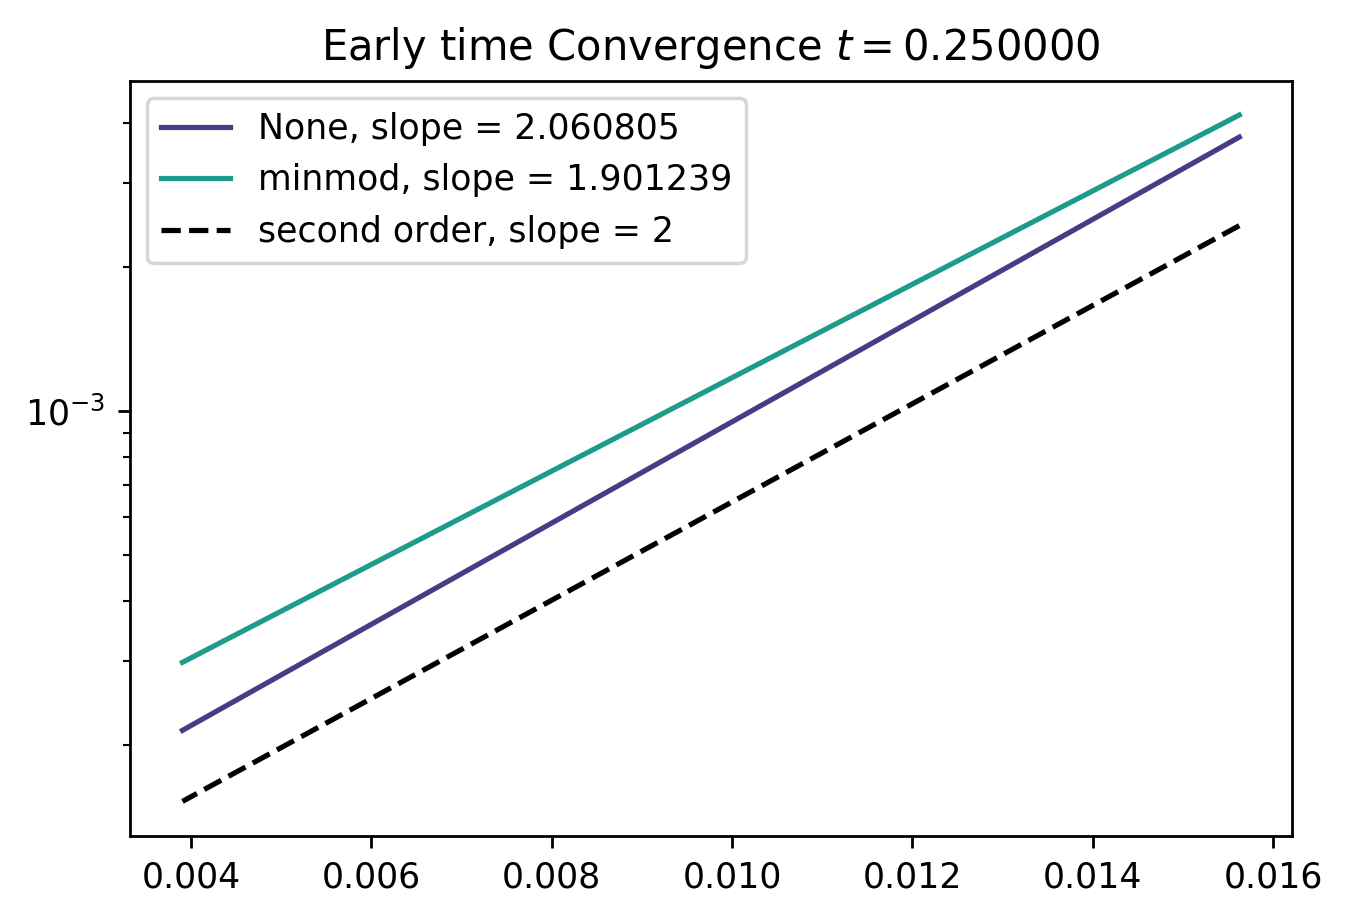

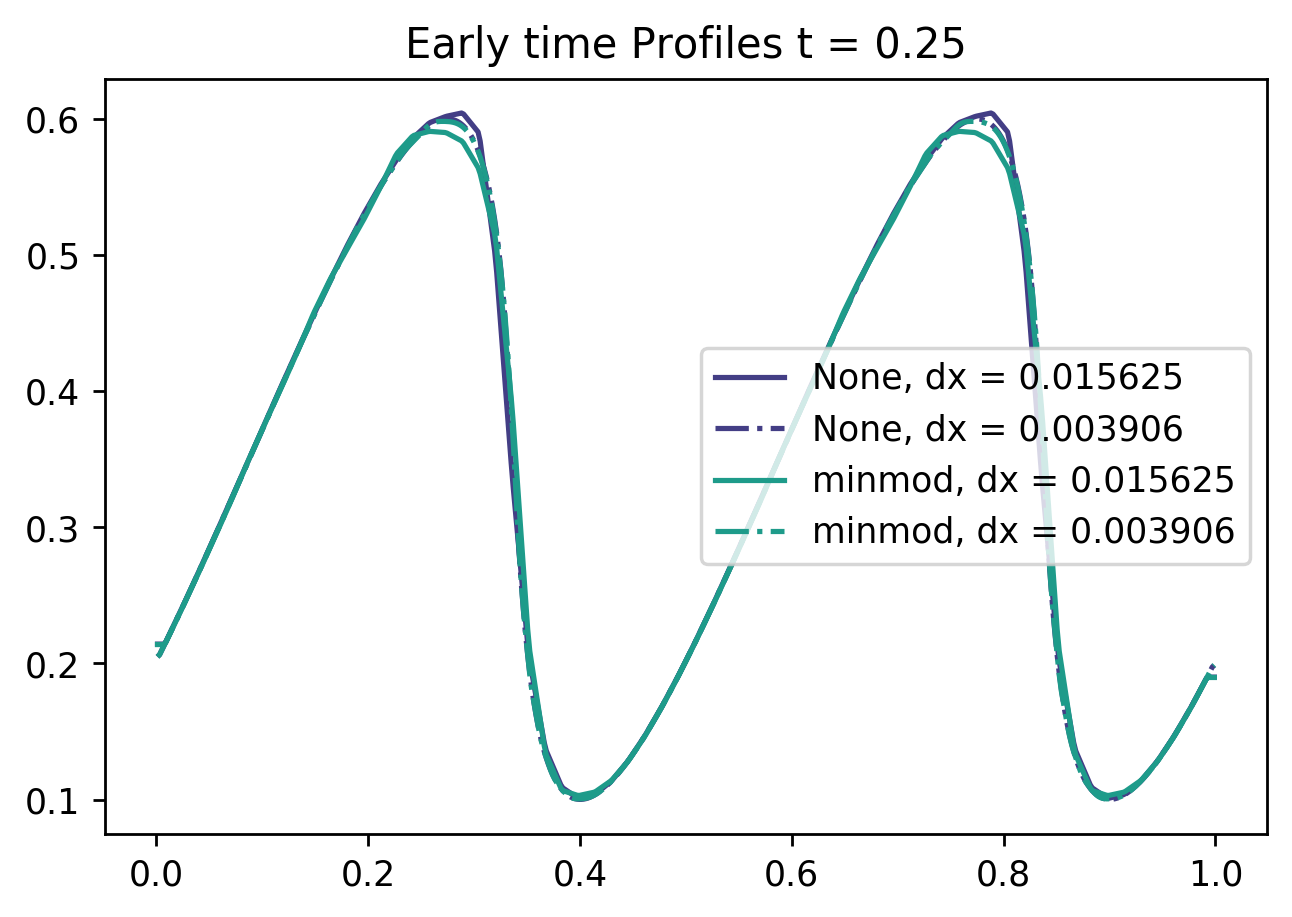

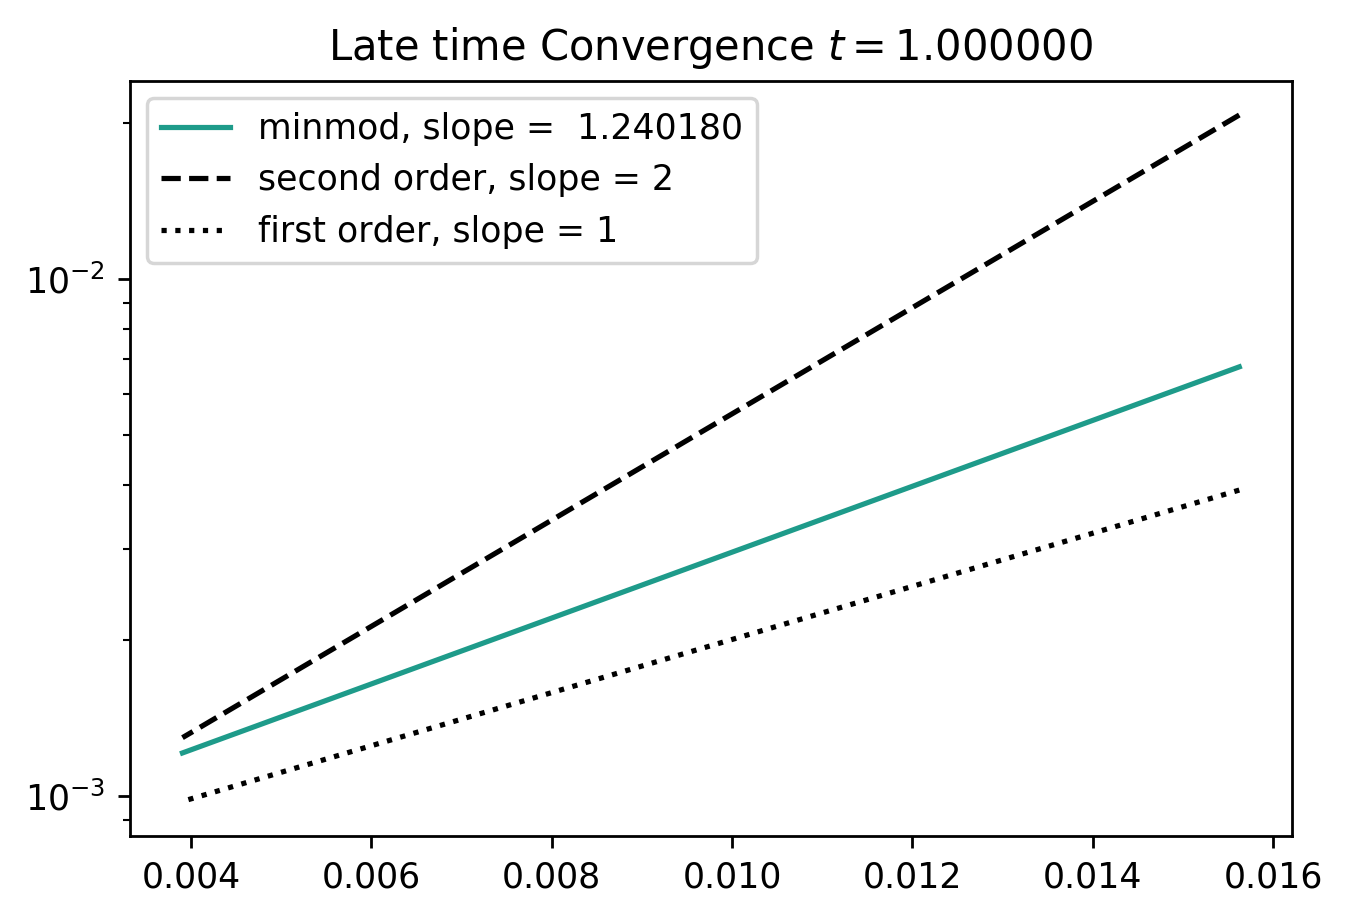

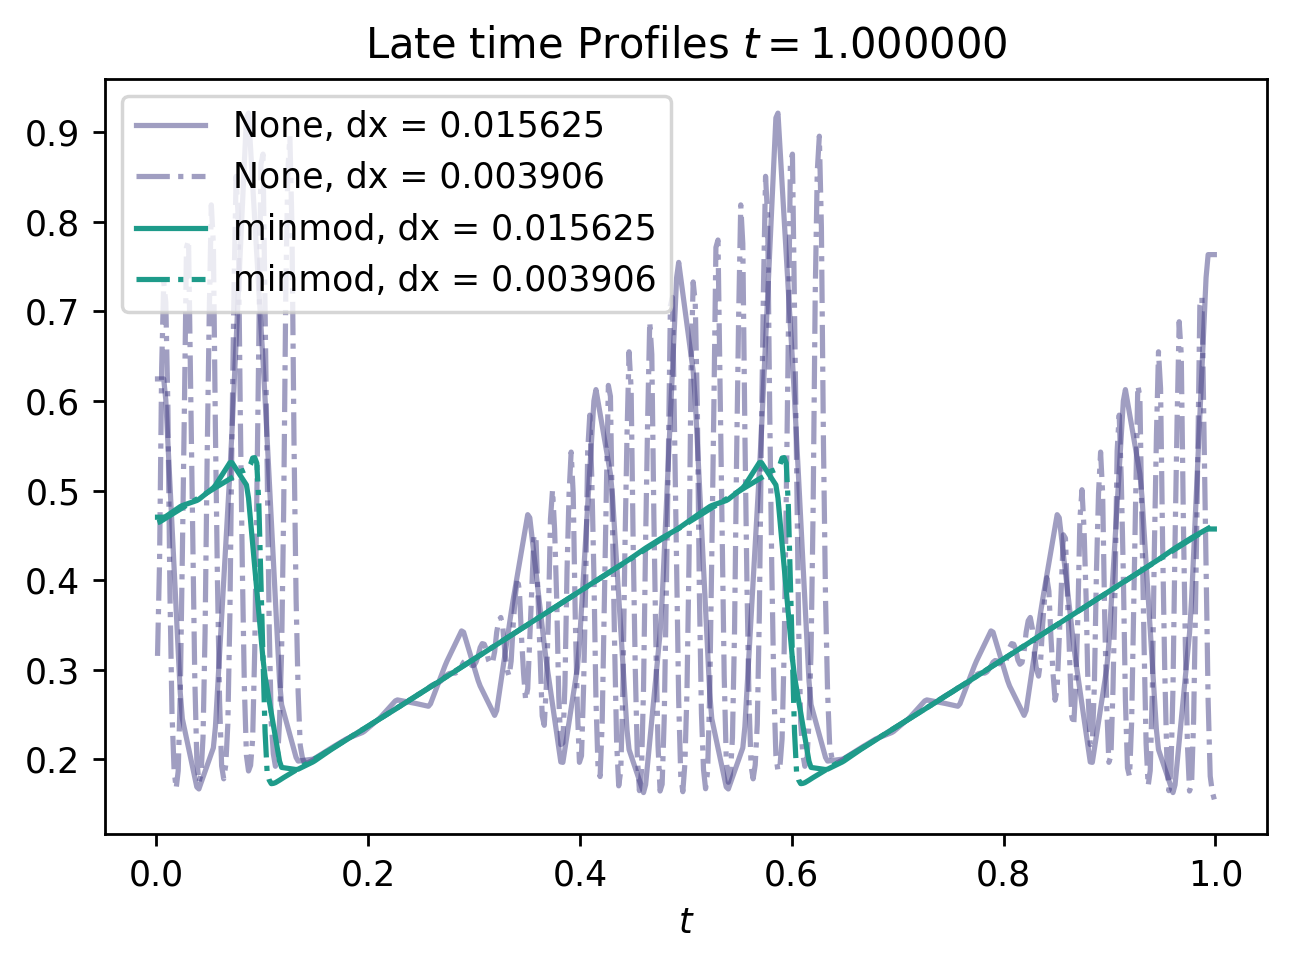

In [17]:
#==============================#
#   Plotting styles
i_early = 0
i_late  = -1
STYLE = ['-', '-.', '--']
COLOR = [0.2, 0.5, 0.75, 1.0]
#==============================#

plt.figure(1)
plt.title('Early time Convergence $t = %f$'%tf_vals[i_early])
cmap1 = plt.cm.get_cmap('viridis', 12)
for n in range(len(slope_limiter_types)):
    plt.semilogy(deltaX_vals, error[n,i_early], color = cmap1(COLOR[n]), label = r'%s, slope = %f'%(slope_limiter_types[n] , 
                slopes[n][i_early])) 

plt.semilogy(deltaX_vals, 1e1*deltaX_vals**2, label = 'second order, slope = 2', color = 'k', linestyle = '--')
plt.legend()
plt.savefig(filepath + 'Plots/Early_time_convergence.png', dpi = 100)


plt.figure(2)
plt.title('Early time Profiles t = {}'.format(tf_vals[i_early]))
for n in range(len(slope_limiter_types)):
    for j in range(Ncells_vals.shape[0]):
        plt.plot(x_original[n][i_early][j][:], u_profiles[n][i_early][j][:], color = cmap1(COLOR[n]), 
                 linestyle = STYLE[j],  label = slope_limiter_types[n] + ", dx = %f"%deltaX_vals[j])
plt.legend()
plt.savefig(filepath + 'Plots/Early_time_profiles{}.png'.format(tf_vals[i_early]))


plt.figure(3)
plt.title('Late time Convergence $t = %f$'%tf_vals[i_late])
cmap2 = plt.cm.get_cmap('plasma', 12)
for n in [1]: #only plot the minmod
    plt.semilogy(deltaX_vals, error[n,i_late], color = cmap1(COLOR[n]), label = r'%s, slope =  %f'%(slope_limiter_types[n],  
                slopes[n][i_late])) 
plt.semilogy(deltaX_vals, 8.5e1*deltaX_vals**2, label = 'second order, slope = 2', color = 'k', linestyle = '--')
plt.semilogy(deltaX_vals, 2.5e-1*deltaX_vals, label = 'first order, slope = 1', color = 'k', linestyle = ':')
plt.legend()
plt.savefig(filepath + 'Plots/Late_time_convergence.png', dpi = 100)


plt.figure(4)
plt.title('Late time Profiles $t = %f$'%tf_vals[i_late])
plt.xlabel(r'$t$')

for n in range(len(slope_limiter_types)):
    for j in range(Ncells_vals.shape[0]):
        plt.plot(x_original[n][i_late][j][:], u_profiles[n][i_late][j][:], color = cmap1(COLOR[n]), 
                 linestyle = STYLE[j], alpha = (n+1)/2, label = slope_limiter_types[n] + ", dx = %f"%deltaX_vals[j])
plt.legend()
plt.savefig(filepath + 'Plots/Late_time_profiles{}.png'.format(tf_vals[i_early]))